## SUM149 and SUM159 cell line analysis

**Author:Dr.Xi Li**

**Created: 01/21/21**

**Language: Python**

This document serves to provide analysis to SUM149 and SUM159 data it takes as imput is a loom file extracted from velocyto and provides H5d5 for storage, as well as several figures and tables as output.


NOTE: cyto trace file must be present in the directory that this script is located in

In [1]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scvelo as scv
import loompy
import pandas as pd
import numpy as np
import os
import scanpy as sc
import scipy.stats as stats
from io import StringIO
from sklearn import linear_model
import seaborn as sns
 
%matplotlib inline

In [2]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# for beautified visualization

## input sample path

First lets find the directory that we are working in

**Note:  SigsDir must be changed depending on the user to allow for proper use of this script**

In [3]:
os.getcwd()

'/mnt/c9b6130c-37e5-4f62-becc-dd4240b42021/T127_T22_ola_2'

In [4]:
#set directory to where signature gene lists locates
SigsDir="/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/sig"

## Unique Gene Names

First we want to select the genes that we wish to look at and format them into a data frame that we can use later on

In [14]:
#set the directory for outputs
project_ID="pool_reconcat"
scv.settings.figdir=f'{project_ID}_figures'

In [19]:
#load data
adata=scv.read (f"{project_ID}.h5ad")
adata.raw=adata

In [16]:
#set sample_id
Sample_idx=pd.Series("Unknown", index=adata.obs_names)
m=0
for i in np.unique(adata.obs.treatment):   
    Sample_idx[adata.obs.treatment==i]=m
    m=m+1
adata.obs["Sample_idx"]=Sample_idx.values
adata.obs["Sample_idx"]=adata.obs["Sample_idx"].astype(float)

In [ ]:
#store a h5ad file for further faster loadinig
adata.var_names_make_unique("_")

#we need to make a directory to store the files in
try:
    directoryName=project_ID+"_figures"
    os.mkdir(directoryName)
except:
    pass

#we need to make a directory to store the files in

try:
    directoryName=project_ID+"_DEG"
    os.mkdir(directoryName)
except:
    pass


## Preprocess the Data

now we will take the files from the previous section where we determined spliced/unspliced RNA counts and use them to create RNA velocity trajectory as well as investigate biological alternation in each cell

In [47]:
#calculate the percentage of mitochondrial genes and ribosomal genes
adata.var['mt'] = adata.var_names.str.startswith('mt-')
adata.var['rp'] = adata.var_names.str.startswith('Rp')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['rp'], percent_top=None, log1p=False, inplace=True)
#sc.pl.violin(adata, ['n_vars'], groupby='Sample_ID', stripplot=False) 

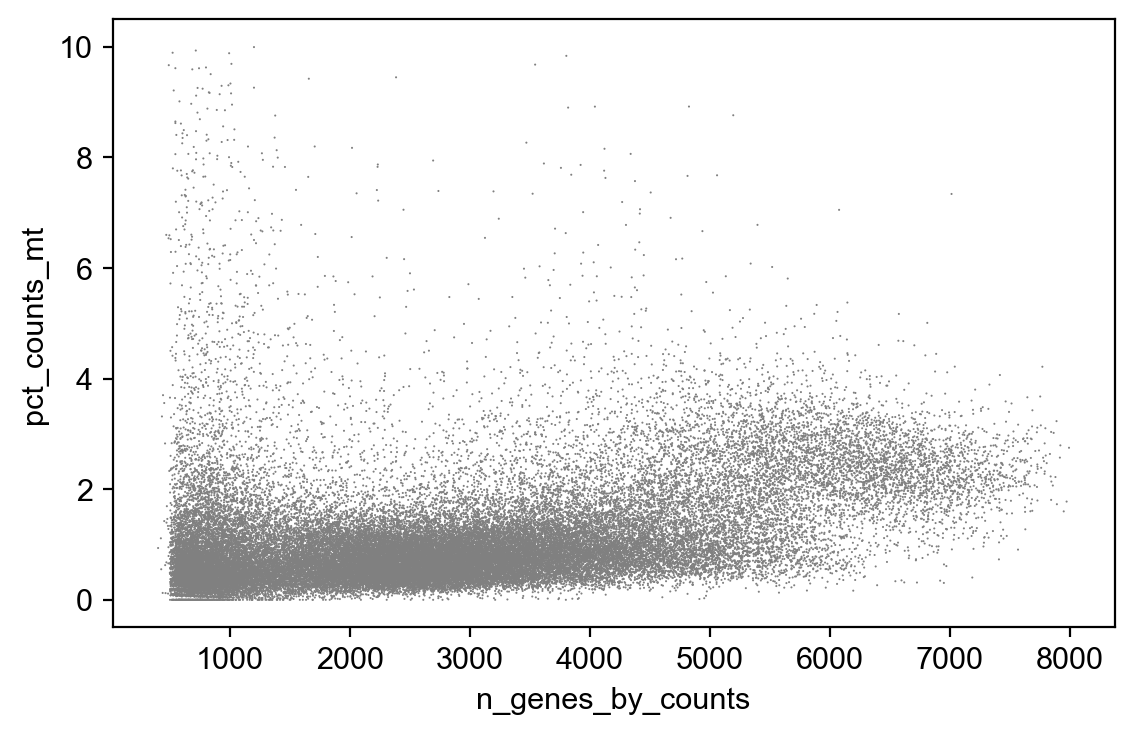

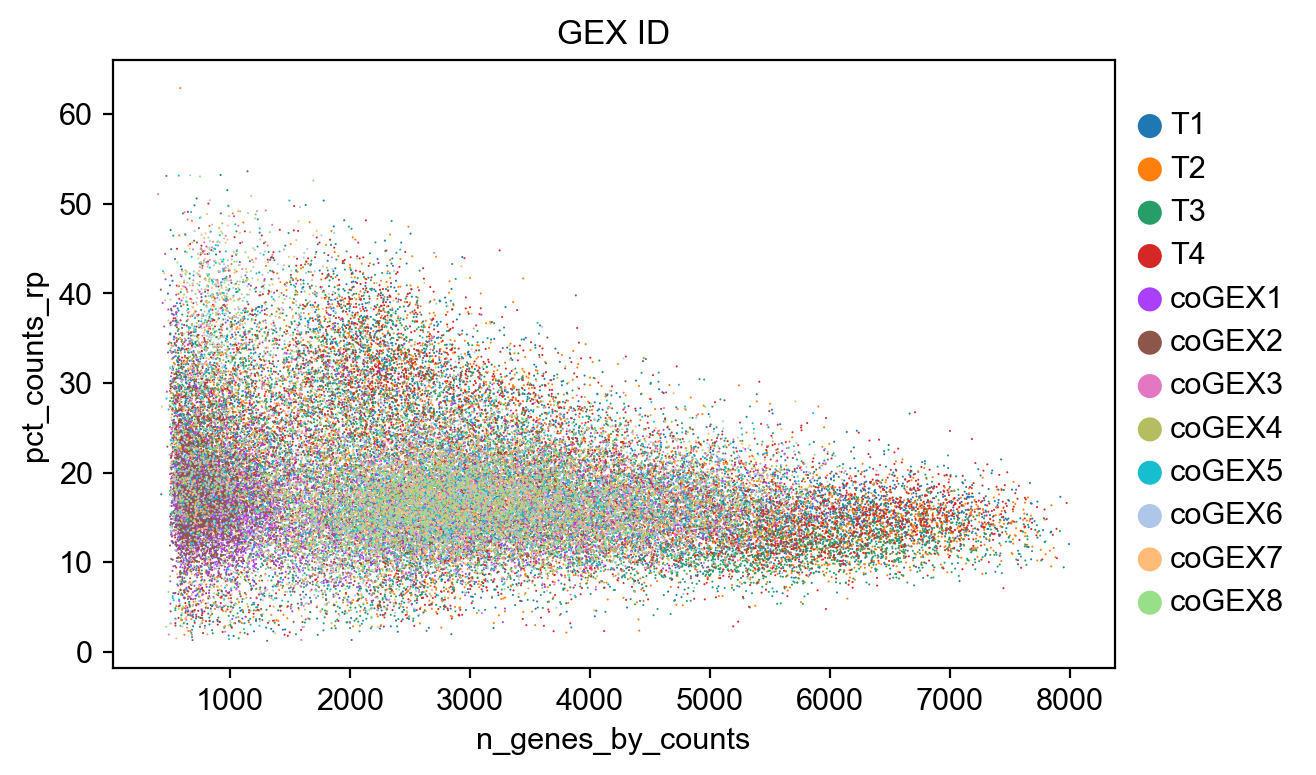

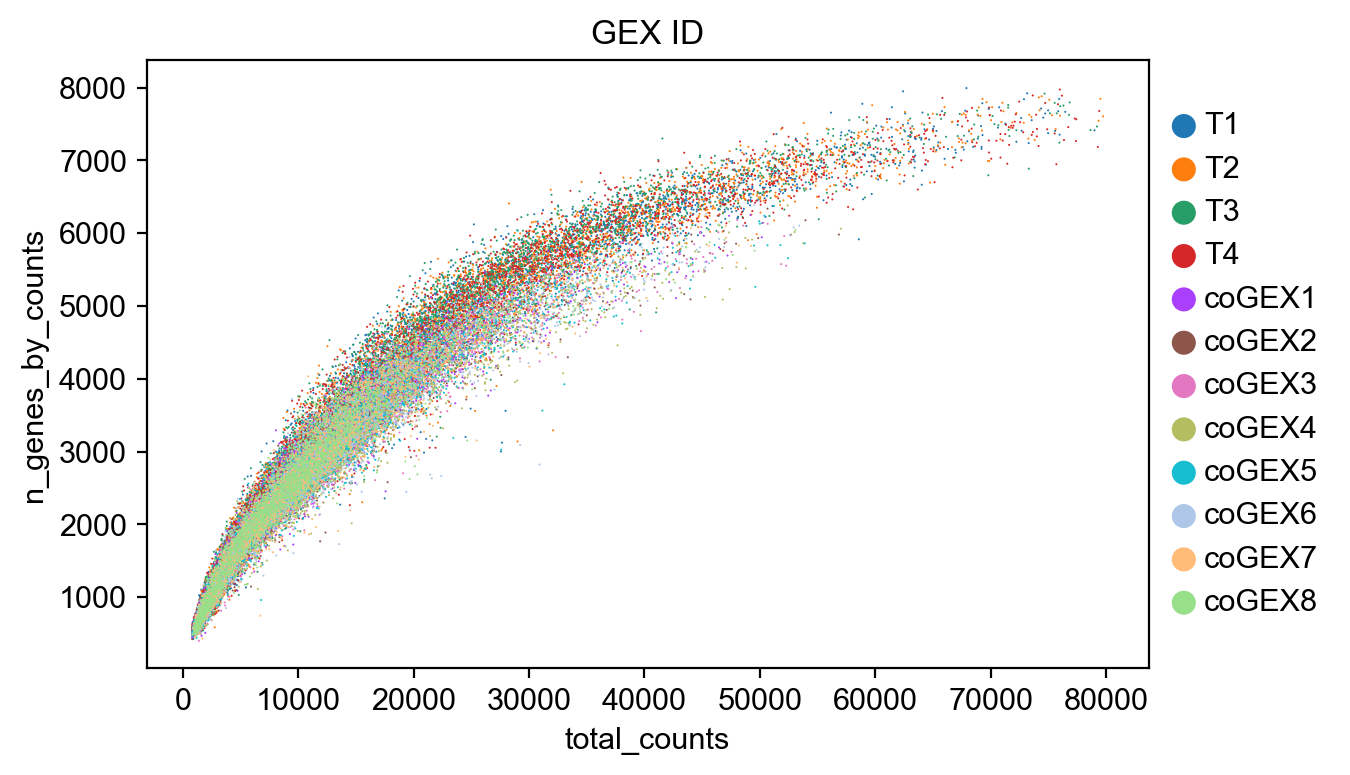

In [48]:
#plot scatter plots of dataset QC
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt')#, color="GEX_ID",)
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_rp', color="GEX_ID",)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',color="GEX_ID")

In [ ]:
#filter out outliers
adata = adata[adata.obs.n_genes_by_counts < 8000, :] #we want the cell to contain less than 5000 total gene detected in order to avoid doublets
adata = adata[adata.obs.total_counts < 80000, :]
adata = adata[adata.obs.n_genes_by_counts > 2000, :] #we want the cell to contain more than 200 total gene detected in order to avoid bad cells
adata = adata[adata.obs.total_counts > 6000, :]# we want the cell to contain more than 400 (200*2) total counts (UMI) detected in order to avoid bad cells
adata = adata[adata.obs.pct_counts_mt < 10, :]# we want the cell to contain less than 55 percent mitochondrial genes in order to avoid bad cells

adata

**Doublets section**

This section should only be used if the dataframe contains doublets.


In [ ]:
#calculate doublets but we don't do this for SUM149 datasets
import scrublet as scr
scrub = scr.Scrublet(adata.raw.X, expected_doublet_rate=0.06,n_neighbors=0.5*np.sqrt(adata.n_obs))

In [ ]:
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets(min_counts=5, 
                                                          min_cells=0.1%(len(adata.to_df())), 
                                                          min_gene_variability_pctl=95, 
                                                          n_prin_comps=30)
scrub.plot_histogram()

In [ ]:
singlet_list = [cells for cells in adata.obs_names if not adata.obs['predicted_doublets'][cells]]
adata = adata[singlet_list,:]

**Continued data processing**

In [56]:
scv.pp.filter_and_normalize(adata,min_cells=0.001*(adata.n_obs), n_top_genes=4000,flavor="cell_ranger")
scv.tl.score_genes_cell_cycle(adata, s_genes= ['Mcm5', 'Pcna', 'Tyms', 'Fen1', 'Mcm2', 'Mcm4', 'Rrm1', 'Ung', 'Gins2',
     'Mcm6', 'Cdca7', 'Dtl', 'Prim1', 'Uhrf1', 'Mlf1ip', 'Hells', 'Rfc2',
     'Rpa2', 'Nasp', 'Rad51ap1', 'Gmnn', 'Wdr76', 'Slbp', 'Ccne2', 'Ubr7',
     'Pold3', 'Msh2', 'Atad2', 'Rad51', 'Rrm2', 'Cdc45', 'Cdc6', 'Exo1', 'Tipin',
     'Dscc1', 'Blm', 'Casp8ap2', 'Usp1', 'Clspn', 'Pola1', 'Chaf1b', 'Brip1', 'E2f8'], g2m_genes = ['Hmgb2', 'Cdk1', 'Nusap1', 'Ube2c', 'Birc5', 'Tpx2', 'Top2a', 'Ndc80',
     'Cks2', 'Nuf2', 'Cks1b', 'Mki67', 'Tmpo', 'Cenpf', 'Tacc3', 'Fam64a',
     'Smc4', 'Ccnb2', 'Ckap2l', 'Ckap2', 'Aurkb', 'Bub1', 'Kif11', 'Anp32e',
     'Tubb4b', 'Gtse1', 'Kif20b', 'Hjurp', 'Cdca3', 'Hn1', 'Cdc20', 'Ttk',
     'Cdc25c', 'Kif2c', 'Rangap1', 'Ncapd2', 'Dlgap5', 'Cdca2', 'Cdca8',
     'Ect2', 'Kif23', 'Hmmr', 'Aurka', 'Psrc1', 'Anln', 'Lbr', 'Ckap5',
     'Cenpe', 'Ctcf', 'Nek2', 'G2e3', 'Gas2l3', 'Cbx5', 'Cenpa']) # calculate cell cycle score with scv internal function and its gene list of s phase and g2m phase, then we will have two observations---"S_score" and "G2M_score" added in adata 
sc.pp.regress_out(adata, keys=["S_score","G2M_score","total_counts","n_genes_by_counts"] , n_jobs=None, copy=False) # we remove cell cycle effects
scv.pp.moments(adata,n_pcs=10, n_neighbors=50, mode="distances") # we calculate a moment matrix for further RNA velocity analysis

Filtered out 15169 genes that are detected in less than 53.946 cells (spliced).
Normalized count data: X, spliced, unspliced.
Extracted 4000 highly variable genes.


Logarithmized X.
calculating cell cycle phase


... storing 'phase' as categorical


-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)
computing neighbors
    finished (0:00:37) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on distances
    finished (0:00:08) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [57]:
#calculate umap
scv.tl.umap(adata, n_components=2, min_dist=0.7, spread=1, maxiter=None, alpha=1.0,
            gamma=1, negative_sample_rate=5, init_pos="spectral", random_state=0, a=None,
            b=None, copy=False, method="umap", neighbors_key=None)

In [58]:
#calculate louvain clusters based on the umap we generated previously
sc.tl.leiden(adata, resolution=2,  
                 key_added='leiden', use_weights=True)
adata.obs["clusters"]=adata.obs["leiden"]

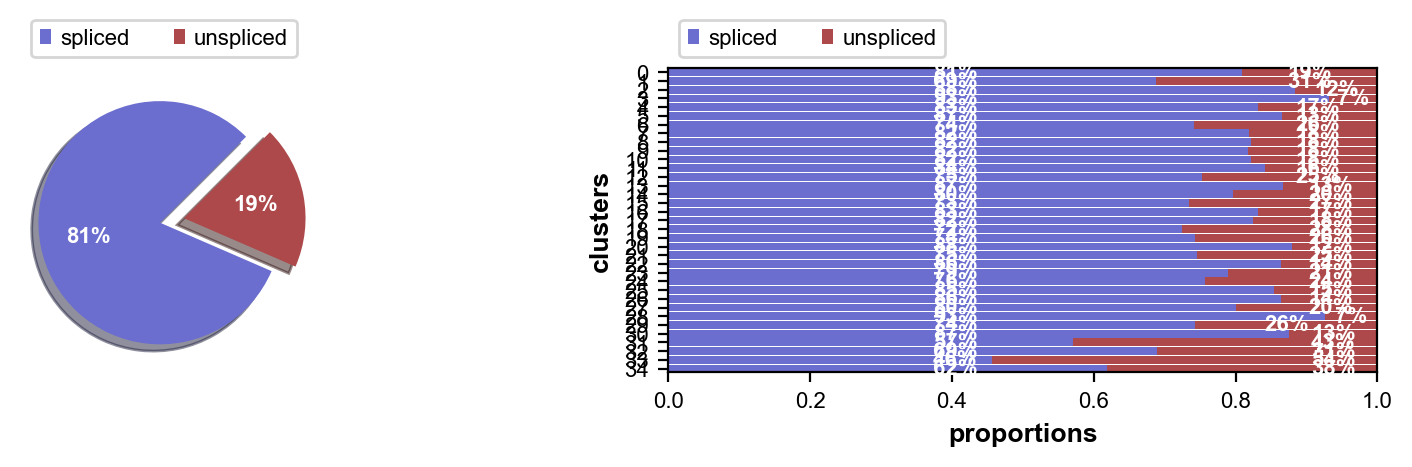

In [59]:
#check proportions of spliced and unspliced RNA in each cluster
scv.pl.proportions(adata)

In [ ]:
import densmap

In [ ]:
#This section can create a densmap if disired 
embedding, ro, re = densmap.densMAP(n_neighbors=200, n_epochs=500, dens_frac=0.7,
                                    min_dist=0.5,spread=1.5,
                                    dens_lambda=0.5).fit_transform(adata.to_df(layer="Ms"))
    
#input densmap information into adata
adata.obsm["X_densmap"]=embedding

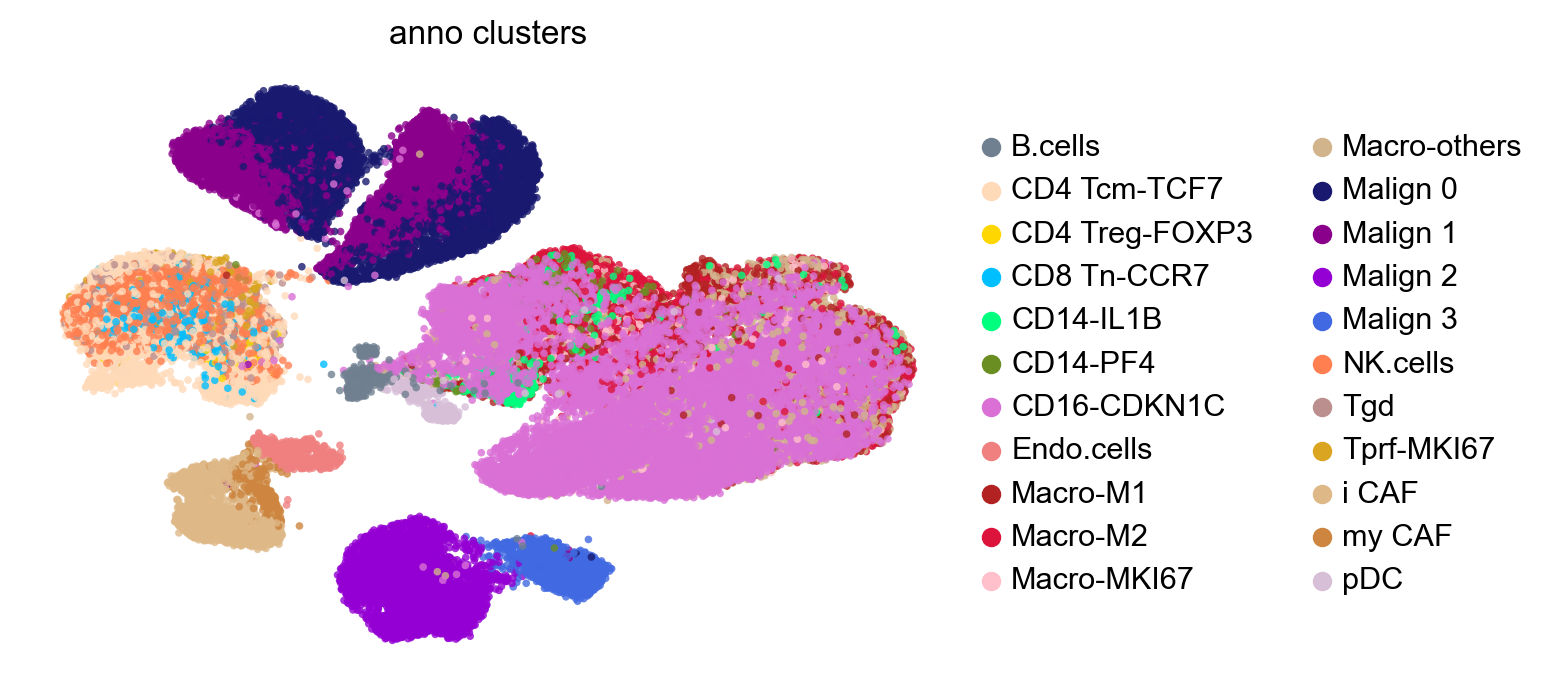

In [60]:
#plot umap grouped by treatment
plot_pattern="anno_clusters"
scv.pl.scatter(adata,# save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=30, alpha=0.8,
            palette=[ "slategrey","PeachPuff","gold",
                     "DeepSkyBlue",
                     "SpringGreen","olivedrab",
                     "orchid","lightcoral","firebrick","crimson","Pink", "tan",
                   "MidnightBlue", "DarkMagenta", "darkviolet","royalblue", 
                   "coral","RosyBrown","Goldenrod","BurlyWood","Peru",
            "Thistle","lightseagreen","CadetBlue",
            "lightsteelblue","dimgrey","black","IndianRed","PaleVioletRed","hotpink","greenyellow","forestgreen","PaleTurquoise","Aqua",] )

In [ ]:
#plot umap grouped by treatment
plot_pattern="treatment"
scv.pl.scatter(adata,,# save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=30, alpha=0.8,
            palette=[ "slategrey","PeachPuff","gold",
                     "DeepSkyBlue",
                     "SpringGreen","olivedrab",
                     "orchid","lightcoral","firebrick","crimson","Pink", "tan",
                   "MidnightBlue", "DarkMagenta", "darkviolet","royalblue", 
                   "coral","RosyBrown","Goldenrod","BurlyWood","Peru",
            "Thistle","lightseagreen","CadetBlue",
            "lightsteelblue","dimgrey","black","IndianRed","PaleVioletRed","hotpink","greenyellow","forestgreen","PaleTurquoise","Aqua",] )

In [ ]:
#plot umap grouped by treatment
plot_pattern="phase"
scv.pl.scatter(adata, save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=10, alpha=0.8,
            palette=[ "orchid","lightcoral","firebrick","crimson",
                     "coral","Peru","DarkMagenta","DeepSkyBlue","SpringGreen","lightseagreen","olivedrab",
                     "Aqua","CadetBlue","royalblue","MidnightBlue",
                    "lightsteelblue", "dimgrey","slategrey","black","RosyBrown","Goldenrod","tan","BurlyWood",
            "IndianRed","PaleVioletRed","hotpink","greenyellow","forestgreen","PaleTurquoise","PeachPuff","gold",
                      "Thistle", "Pink", "darkviolet",] )

saving figure to file pool_reconcat_new_new_new_figures/scvelo_anno_clusters_umap.pdf


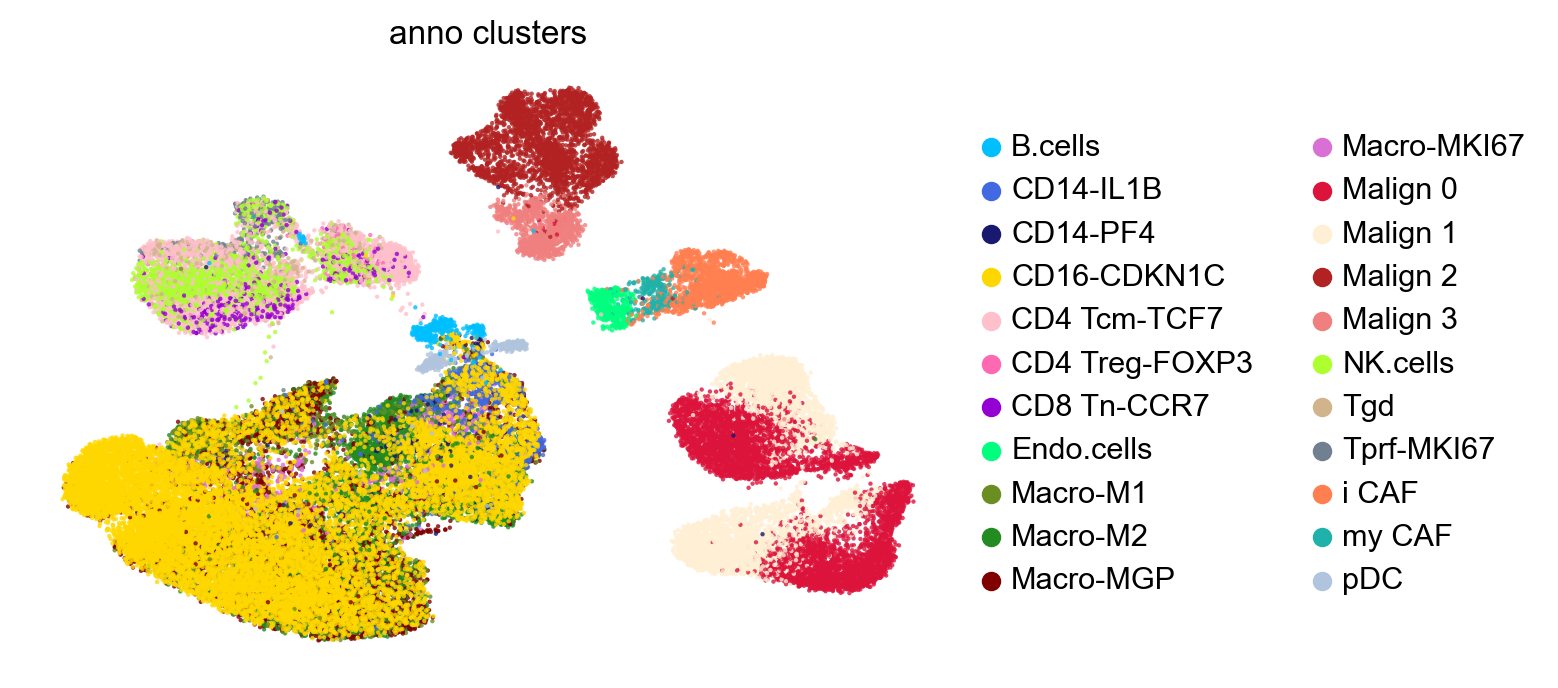

In [48]:
#plot umap grouped by treatment
plot_pattern="anno_clusters"
scv.pl.scatter(adata, save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=10, alpha=0.8,
            palette=[ "DeepSkyBlue","royalblue","MidnightBlue","gold","Pink","hotpink","darkviolet",
                    "SpringGreen","olivedrab","forestgreen","maroon"
            ,"orchid","crimson","PapayaWhip"
            ,"firebrick","lightcoral","greenyellow"
            ,"tan","slategrey","coral","lightseagreen"
            ,"lightsteelblue","lightskyblue","dimgrey",
            "indigo","darkturquoise"], )

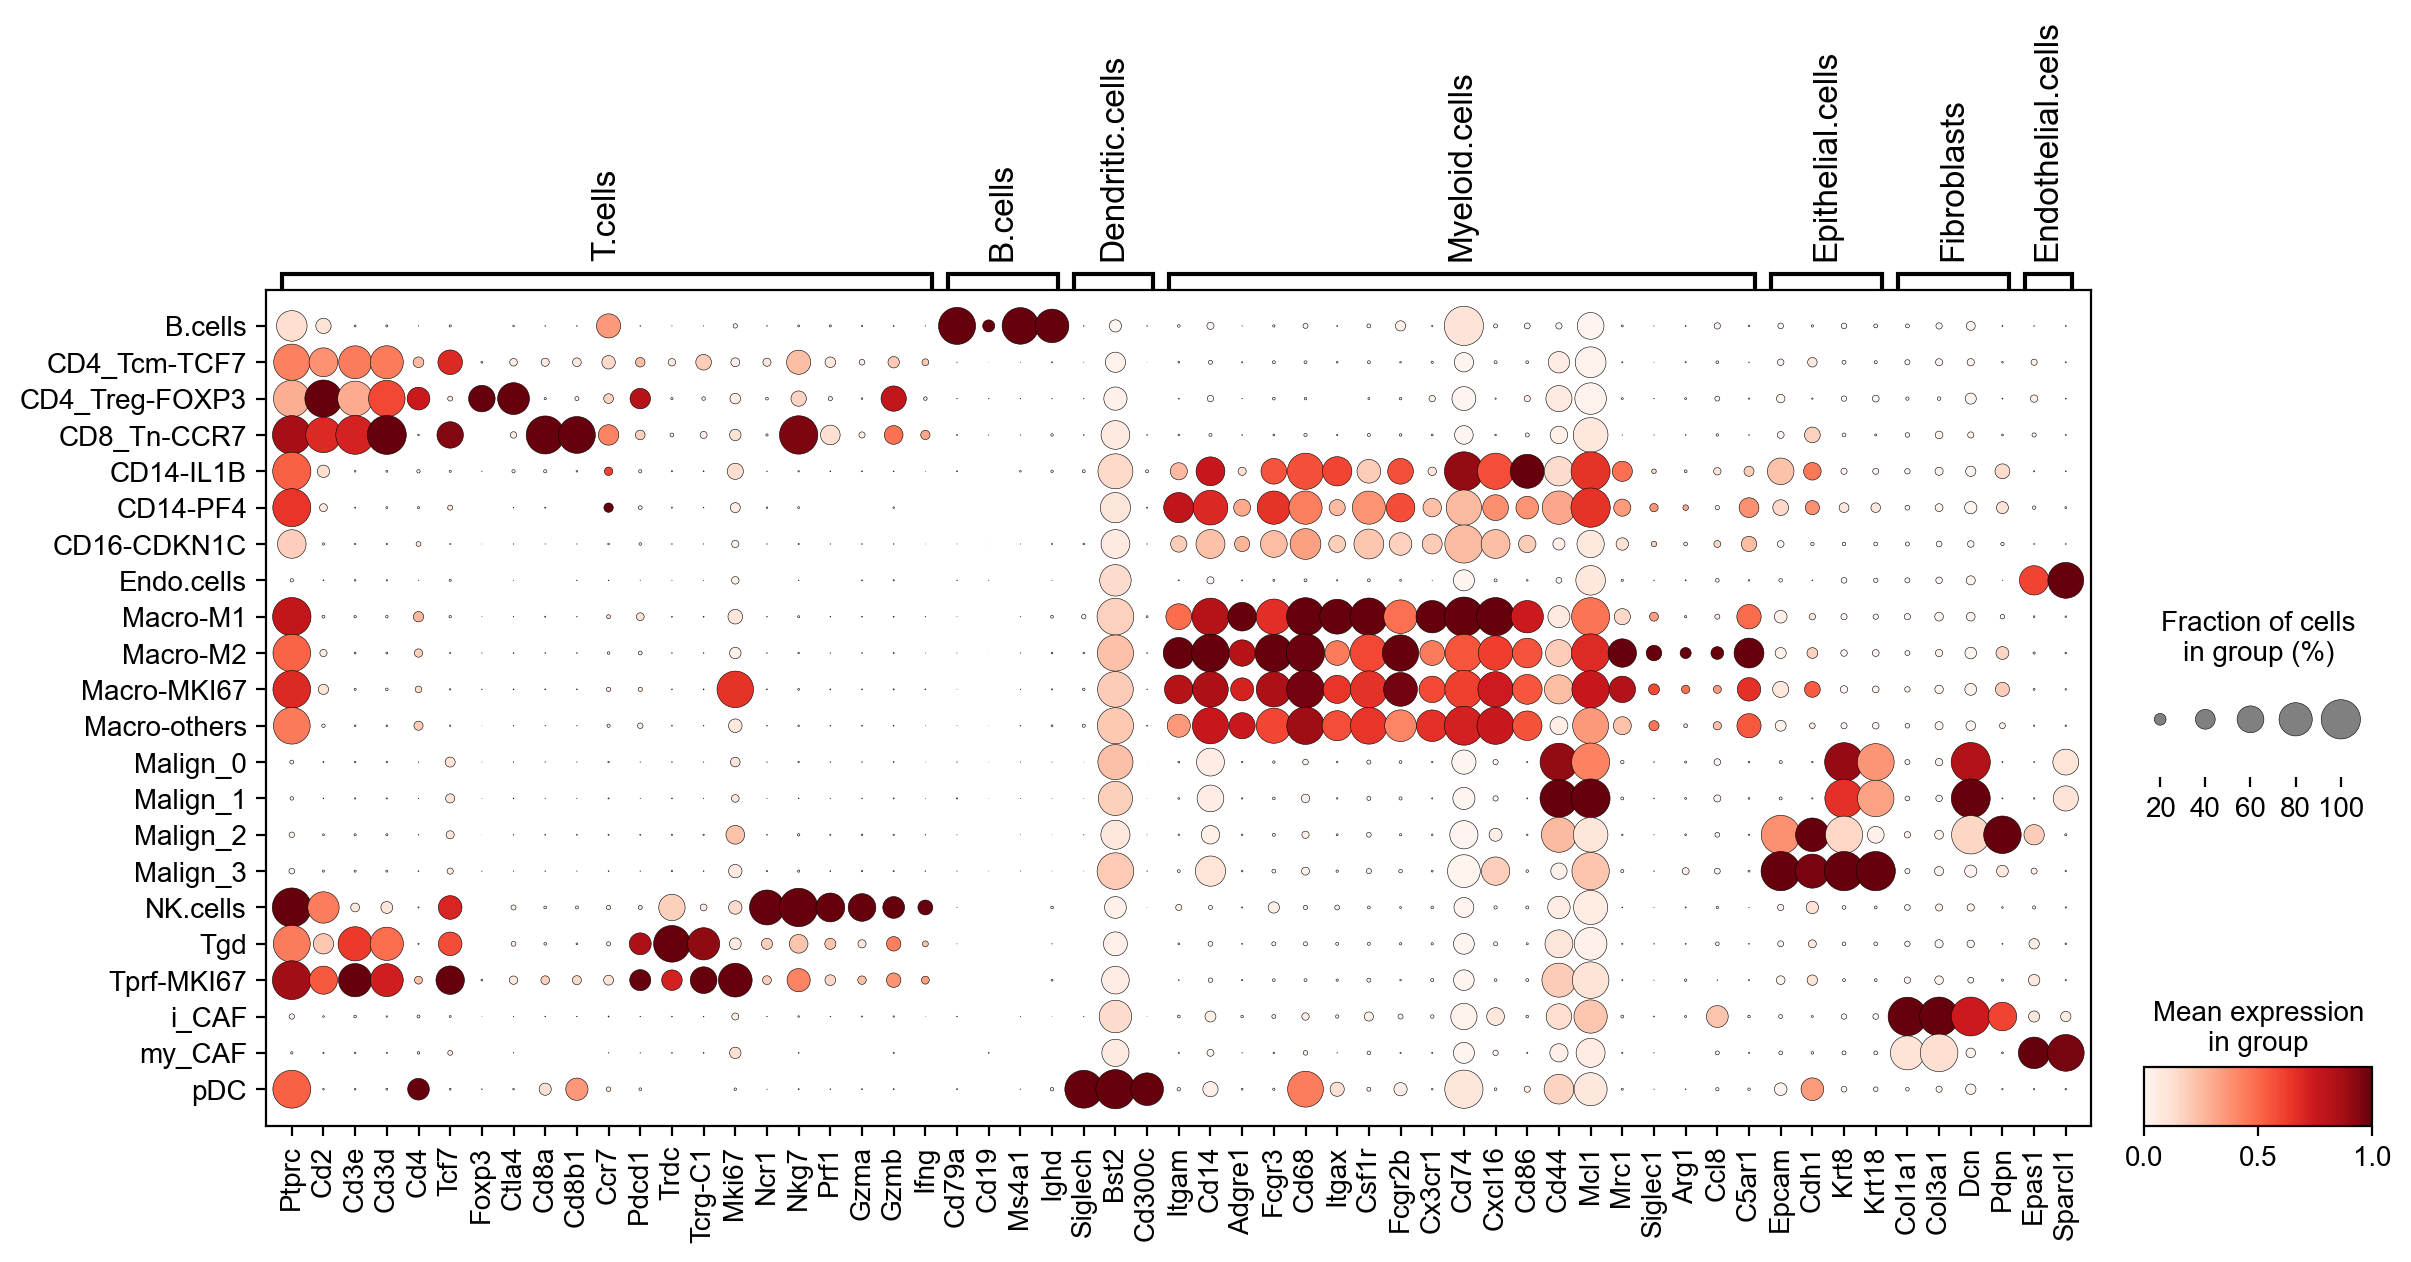

In [62]:
#sc.tl.dendrogram(adata,groupby="anno_clusters10")
markers ={
    "T.cells":["Ptprc","Cd2","Cd3e","Cd3d","Cd4","Tcf7","Foxp3","Ctla4","Cd8a","Cd8b1","Ccr7","Pdcd1","Trdc","Tcrg-C1","Mki67","Ncr1","Nkg7","Prf1","Gzma","Gzmb","Ifng"],
    "B.cells":["Cd79a","Cd19","Ms4a1","Ighd"],
    "Dendritic.cells":["Siglech","Bst2","Cd300c"],
    "Myeloid.cells":["Itgam","Cd14","Adgre1","Fcgr3","Cd68","Itgax","Csf1r","Fcgr2b","Cx3cr1", "Cd74","Cxcl16","Cd86",
                     "Cd44","Mcl1","Mrc1","Siglec1","Arg1","Ccl8","C5ar1"],
     "Epithelial.cells":["Epcam","Cdh1","Krt8","Krt18"],   
    "Fibroblasts":["Col1a1","Col3a1","Dcn","Pdpn"],
    "Endothelial.cells":["Epas1","Sparcl1"],
   
    }

sc.pl.dotplot(adata, markers,standard_scale="var",cmap="Reds"
              ,figsize=(13.5,5.5),
                     mean_only_expressed=False, expression_cutoff=0,use_raw=True,
                     groupby='anno_clusters', dendrogram=False,save=f"{project_ID}_markers_T.pdf")

saving figure to file pool_reconcat_new_new_new_figures/scvelo_anno_clusters_umap.pdf


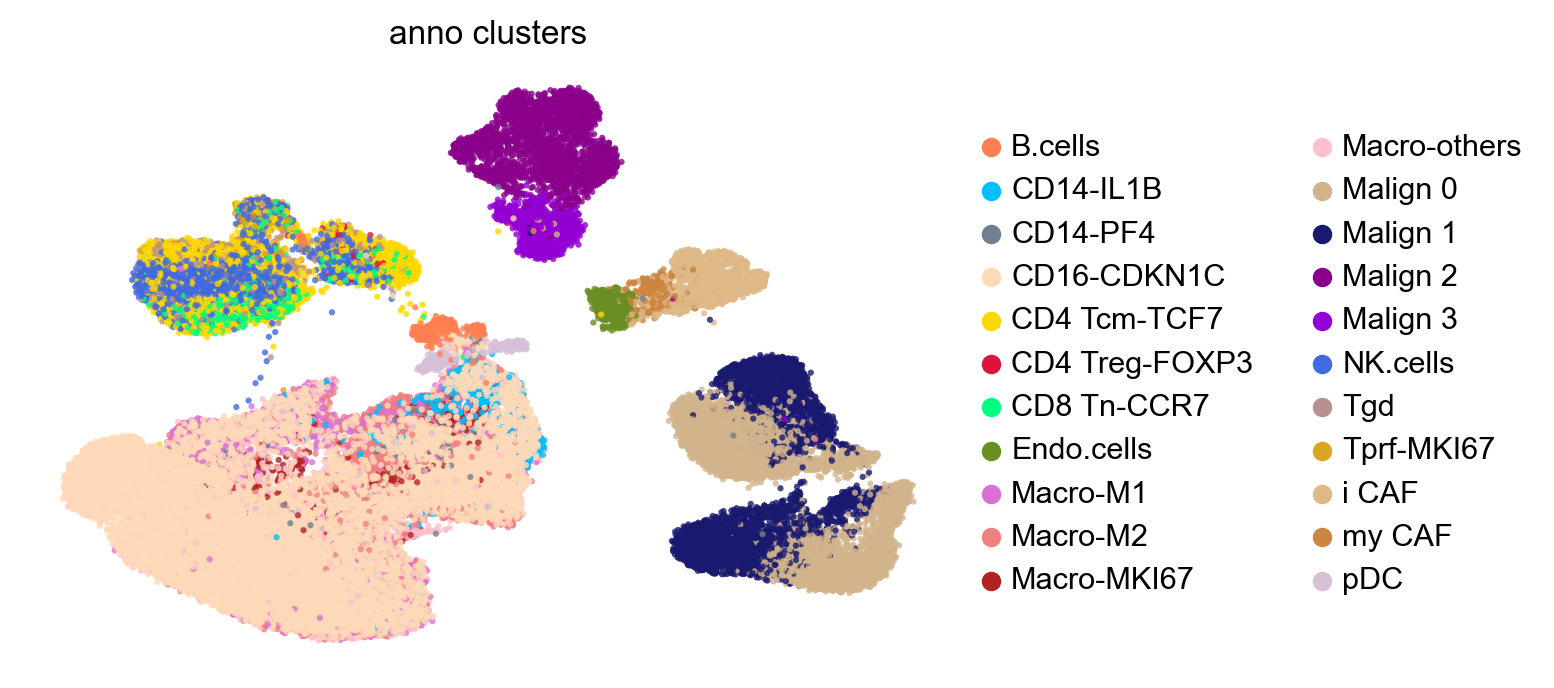

In [53]:
#plot umap grouped by treatment
plot_pattern="anno_clusters"
scv.pl.scatter(adata, save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=20, alpha=0.8,
            palette=[ "coral",
                     "DeepSkyBlue","slategrey","PeachPuff","gold","crimson",
                     "SpringGreen","olivedrab","orchid",
                     "lightcoral","firebrick","Pink", "tan",
                   "MidnightBlue", "DarkMagenta", "darkviolet","royalblue", 
                   "RosyBrown","Goldenrod","BurlyWood","Peru",
            "Thistle","lightseagreen","CadetBlue",
            "lightsteelblue","dimgrey","black","IndianRed","PaleVioletRed","hotpink","greenyellow","forestgreen","PaleTurquoise","Aqua",] )

In [ ]:
#plot umap grouped by treatment
plot_pattern="RSR_clusters"
scv.pl.scatter(adata, save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=20, alpha=0.8,
            palette=[ "coral",
                     "DeepSkyBlue","slategrey","PeachPuff","gold","crimson",
                     "SpringGreen","olivedrab","orchid",
                     "lightcoral","firebrick","Pink", "tan",
                   "MidnightBlue", "DarkMagenta", "darkviolet","royalblue", 
                   "RosyBrown","Goldenrod","BurlyWood","Peru",
            "Thistle","lightseagreen","CadetBlue",
            "lightsteelblue","dimgrey","black","IndianRed","PaleVioletRed","hotpink","greenyellow","forestgreen","PaleTurquoise","Aqua",] )

In [ ]:
 markers={
    "Class Ia":[genes for genes in ['H2-K1','H2-Ke6', 'H2-D1',] if genes in adata.var_names],
    "Class Ib":[genes for genes in['H2-T24', 'H2-T23','H2-T22','H2-T3','H2-Q1', 'H2-Q2', 'H2-Q4', 'H2-Q6', 'H2-Q7', 'H2-Q10', ]if genes in adata.var_names],
    "Class II":[genes for genes in[  'H2-Aa',  'H2-M10.2', 'H2-M10.1', 'H2-M10.3',
         'H2-M10.4','H2-M9', 'H2-M1','H2-M5','H2-M2', 'H2-Oa', 'H2-DMa', 'H2-DMb2', 'H2-DMb1','H2-Ob', 'H2-Ab1', 'H2-Eb1', 'H2-Eb2',
         'H2-M11', 'H2-M10.5', 'H2-M10.6', 'H2-M3']if genes in adata.var_names]
}
sc.pl.dotplot(adata, markers ,cmap="jet",standard_scale="var",
                     mean_only_expressed=False, expression_cutoff=0,use_raw=False,
                     groupby='anno_clusters', dendrogram=False,save=f"{project_ID}_MHC_treatments_anno_clusters.pdf")

In [ ]:

markers ={
    "Myeloid.cells":["Itgam","Fcgr3"],
    "MDSCs":["Ly6g","Ly6c1","Ly6c2","Lin28a","Cd33","Fut4"],
    "Monocytes":["Cd14","Cd300a","F13a1","Hp","Vcan"],
    "Macrophages":["Lyz2","Cd68","Csf1r","Adgre1","C1qa","C1qb","C1qc"],
    "TREM":["Trem1","Trem2"],
    "M1_TAM":["Cd86","Cx3cr1","Cxcl16",],
    "M2_TAM":["Mrc1","Siglec1","C5ar1"],
    "Microglia":["Tmem119","P2ry12"],
    "Immune_checkpoint":["Cd274","Cd80"],
    "MHC-II":['H2-K1','H2-Aa','H2-T23','H2-M5', 'H2-M2','H2-Oa','H2-DMb2','H2-Ob' ,'H2-Ab1', 'H2-Eb2', 'H2-D1','H2-Q7',]
}

sc.pl.dotplot(adata[adata.obs.treatment.str.startswith("T22_V")], markers,standard_scale="var",cmap="RdYlBu_r",
                     mean_only_expressed=False, expression_cutoff=0,use_raw=True,
                     groupby='anno_clusters2', dendrogram=False,save=f"{project_ID}_clusters.pdf")

In [ ]:
T_cells=["Ptprc","Cd3d","Cd3e","Cd4","Cd8a","Cd8b1","Trac","Trdc","Tcrg-C1"]
Cytotoxic=["Nkg7","Prf1","Cst7","Gzma","Gzmb","Gzmk","Ifng","Ifna1","Tnfsf10","Fasl"]
Exhausted=["Ctla4","Lag3","Pdcd1","Tigit"]
Regulatory=["Foxp3","Il2ra","Tgfb1","Tgfb3","Tgfbi","Tgfbr1"]
Naive=["Ccr7","Lef1","Sell","Tcf7","Cd27"]
Co_stimulatory=["Cd226","Icos","Tnfrsf14","Tnfrsf25","Tnfrsf9","Cd27"]
Proliferation=["Mki67","Top2a"]
Apoptosis_Tolerance=["Gadd45b","Rnf128"]
Vip_receptors=["Vipr1","Vipr2"]

In [ ]:
T_cells=[genes for genes in adata.var_names if genes in T_cells]
Cytotoxic=[genes for genes in adata.var_names if genes in Cytotoxic]
Exhausted=[genes for genes in adata.var_names if genes in Exhausted]
Regulatory=[genes for genes in adata.var_names if genes in Regulatory]
Naive=[genes for genes in adata.var_names if genes in Naive]
Co_stimulatory=[genes for genes in adata.var_names if genes in Co_stimulatory]
Proliferation=[genes for genes in adata.var_names if genes in Proliferation]
Apoptosis_Tolerance=[genes for genes in adata.var_names if genes in Apoptosis_Tolerance]
Vip_receptors=[genes for genes in adata.var_names if genes in Vip_receptors]

In [ ]:
#sc.tl.dendrogram(adata,groupby="Sample")
markers ={
    "T.cells":T_cells,
    "Cytotoxic":Cytotoxic,
    "Exhausted":Exhausted,
    "Regulatory":Regulatory,
    "Naive":Naive,
    "Co-stimulatory":Co_stimulatory,
    "Proliferation":Proliferation,
    "Apoptosis&Tolerance":Apoptosis_Tolerance,
    "Vip receptors":Vip_receptors
}

sc.pl.dotplot(adata[adata.obs.anno_clusters=="CD8-CXCL13"], markers,standard_scale="var",cmap="RdYlBu_r",
                     mean_only_expressed=False, expression_cutoff=0, use_raw=True,
                     groupby='treatment', dendrogram=False)#,save=f"{project_ID}_markers_strains.pdf")

In [ ]:
#sc.tl.dendrogram(adata,groupby="Sample")
markers ={
    "T.cells":T_cells,
    "Cytotoxic":Cytotoxic,
    "Exhausted":Exhausted,
    "Regulatory":Regulatory,
    "Naive":Naive,
    "Co-stimulatory":Co_stimulatory,
    "Proliferation":Proliferation,
    "Apoptosis&Tolerance":Apoptosis_Tolerance,
    "Vip receptors":Vip_receptors
}

sc.pl.dotplot(adata[adata.obs.anno_clusters=="CD8_Teff-GNLY"], markers,standard_scale="var",cmap="RdYlBu_r",
                     mean_only_expressed=False, expression_cutoff=0, use_raw=False,
                     groupby='treatment', dendrogram=False)#,save=f"{project_ID}_markers_strains.pdf")

In [ ]:
#sc.tl.dendrogram(adata,groupby="Sample")
markers ={
    "T.cells":T_cells,
    "Cytotoxic":Cytotoxic,
    "Exhausted":Exhausted,
    "Regulatory":Regulatory,
    "Naive":Naive,
    "Co-stimulatory":Co_stimulatory,
    "Proliferation":Proliferation,
    "Apoptosis&Tolerance":Apoptosis_Tolerance,
    "Vip receptors":Vip_receptors
}

sc.pl.dotplot(adata[adata.obs.anno_clusters=="CD8_Tem-GZMK"], markers,standard_scale="var",cmap="RdYlBu_r",
                     mean_only_expressed=False, expression_cutoff=0, use_raw=False,
                     groupby='treatment', dendrogram=False)#,save=f"{project_ID}_markers_strains.pdf")

In [ ]:
Antigen_presentation=list(map(lambda x:x.capitalize(),pd.read_csv(f"/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/sig/Antigen_presentation.csv",header=None, sep=",", usecols=[0],).squeeze().str.strip().tolist()) )
Cytotoxic_effector_functions=list(map(lambda x:x.capitalize(),pd.read_csv(f"/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/sig/Cytotoxic_effector_functions.csv",header=None, sep=",", usecols=[0],).squeeze().str.strip().tolist()) )
Immune_response=list(map(lambda x:x.capitalize(),pd.read_csv(f"/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/sig/Immune_response.csv",header=None, sep=",", usecols=[0],).squeeze().str.strip().tolist()))
Metabolism=list(map(lambda x:x.capitalize(),pd.read_csv(f"/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/sig/Metabolism.csv",header=None, sep=",", usecols=[0],).squeeze().str.strip().tolist()))
Neuroendocrine_like=list(map(lambda x:x.capitalize(),pd.read_csv(f"/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/sig/Neuroendocrine_like.csv",header=None, sep=",", usecols=[0],).squeeze().str.strip().tolist()))
TGFbeta_Stromal_activity=list(map(lambda x:x.capitalize(),pd.read_csv(f"/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/sig/TGFbeta_Stromal_activity.csv",header=None, sep=",", usecols=[0],).squeeze().str.strip().tolist()))
 

In [ ]:
Antigen_presentation=[genes for genes in adata.raw.var_names if genes in Antigen_presentation]
Cytotoxic_effector_functions=[genes for genes in adata.raw.var_names if genes in Cytotoxic_effector_functions]
Immune_response=[genes for genes in adata.raw.var_names if genes in Immune_response]
Metabolism=[genes for genes in adata.raw.var_names if genes in Metabolism]
Neuroendocrine_like=[genes for genes in adata.raw.var_names if genes in Neuroendocrine_like]
TGFbeta_Stromal_activity=[genes for genes in adata.raw.var_names if genes in TGFbeta_Stromal_activity]

In [ ]:
Antigen_presentation=[genes for genes in adata.var_names if genes in Antigen_presentation]
Cytotoxic_effector_functions=[genes for genes in adata.var_names if genes in Cytotoxic_effector_functions]
Immune_response=[genes for genes in adata.var_names if genes in Immune_response]
Metabolism=[genes for genes in adata.var_names if genes in Metabolism]
Neuroendocrine_like=[genes for genes in adata.var_names if genes in Neuroendocrine_like]
TGFbeta_Stromal_activity=[genes for genes in adata.var_names if genes in TGFbeta_Stromal_activity]

In [ ]:
markers={
    "Antigen_presentation":Antigen_presentation,
    "Cytotoxic_effector_functions":Cytotoxic_effector_functions,
    "Immune_response":Immune_response,
    "TGFbeta_Stromal_activity":TGFbeta_Stromal_activity,
    "Metabolism":Metabolism,
    "Neuroendocrine_like":Neuroendocrine_like
}
dendrogram_list= Antigen_presentation+Cytotoxic_effector_functions+Immune_response+Metabolism+Neuroendocrine_like+TGFbeta_Stromal_activity

# calculate signature scores

In [ ]:
# read in an example gene list
gene_list_name="Reactome_IFNG_mm"# put the gene list file name here, the gene list file should be a csv file
gene_list = pd.read_csv(f"{SigsDir}/{gene_list_name}.csv",header=None, sep=",", usecols=[0],)
# convert dataframe or series to list
gene_list_ = gene_list.squeeze().str.strip().tolist()
#gene_list_ = [x.capitalize() for x in gene_list_]
#calculate a signature expression score by sc internal function. scv cannot calculate a gene list with coefficient
sc.tl.score_genes(adata, score_name=f"{gene_list_name}_score", gene_list=gene_list_, ctrl_size=50, use_raw=False)

In [ ]:
# read in an example gene list
gene_list_random="random_500_Mm"# put the gene list file name here, the gene list file should be a csv file
random_list = pd.read_csv(f"{SigsDir}/{gene_list_random}.csv",header=None, sep=",", usecols=[0],)
# convert dataframe or series to list
random_list_ = random_list.squeeze().str.strip().tolist()
random_list_ = [x.capitalize() for x in random_list_]
random_list_=[genes for genes in random_list_ if genes in adata.to_df(layer="spliced").columns]

In [ ]:
# we can also make a gene list here manuallly and then calculate a signature s
chemotaxis=["CXCL12","CX3CL1","CCL19", "CCL21", "CXCL10"," CXCL11", " CXCL12","CCL2", "CCL3"," CCL4", "CCL5", "CCL10","IL1A","IL1B","IL2","IL12A","IL12A","IL12B","IL12B",]
chemotaxis= [ x.capitalize() for x in chemotaxis]
sc.tl.score_genes(adata, score_name="chemotaxis score", gene_list=chemotaxis, ctrl_size=10, use_raw=False)

In [ ]:
# we can also make a gene list here manuallly and then calculate a signature s
glist= Antigen_presentation+Cytotoxic_effector_functions+Immune_response+Metabolism
sc.tl.score_genes(adata, score_name="immune infiltration score", gene_list=glist, ctrl_size=50 ,use_raw=True)

In [ ]:
# we can also make a gene list here manuallly and then calculate a signature s
anti_tumor_cytokine=["Il1b","Il2","Il12b","1l1a","Tnf","Cxcl9","Cxcl10","Ifng",]
sc.tl.score_genes(adata_t, score_name="antitumor_cytokine_score", gene_list=anti_tumor_cytokine, ctrl_size=10, use_raw=False)

In [ ]:
# we can also make a gene list here manuallly and then calculate a signature s
pro_tumor_cytokine=["Il10","Tgfb1","Ccl17","Ccl3","Ccl22","Ccl24","Ccl2","Vegfa","Il4","Cxcl15","Cxcl1","Cxcl2","Cxcl3",]
sc.tl.score_genes(adata_t, score_name="protumor_cytokine_score", gene_list=pro_tumor_cytokine, ctrl_size=20, use_raw=False)

In [ ]:
gene_list_name="Reactome_IFNG_mm"
gene_list_coe_=pd.read_csv(f"{SigsDir}/{gene_list_name}.csv",header=1, sep=",",usecols=[0,1],index_col=0)
gene_list_coe_=[genes.capitalize() for genes in gene_list_coe.index if genes.capitalize() in adata.to_df(layer="spliced").columns]

In [ ]:
X_score=0
for genes in gene_list_coe_:
    X_score=X_score+adata.to_df(layer="spliced").loc[:,genes]/len(gene_list_coe_)
for genes in random_list_:
    X_score=X_score-adata.to_df(layer="spliced").loc[:,genes]/len(random_list_)
adata.obs[f"Reactome_IFNG_mm_score"]=X_score

In [ ]:
X_score=0
for genes in gene_list_coe_:
    X_score=X_score+gene_list_coe.loc[genes.upper()].values[0]*adata.to_df(layer="spliced").loc[:,genes]
for genes in random_list_:
    X_score=X_score-adata.to_df(layer="spliced").loc[:,genes]
adata.obs["RSR_score"]=X_score

In [ ]:
adata.obs["immune_infiltration_score"]=adata.obs["immune infiltration score"].astype(float)-adata.obs["TGFb score"].astype(float)

## Cell fraction bar charts

In [50]:
# we can plot feature percentage in the population we group cells, treatment or clusters
# first we need to call a cell_fraction matrix containing matched feature and group_by information of each single cell
feature="anno_clusters"
group_by="treatment"#treatment Group
cell_fraction=pd.DataFrame(adata.obs[group_by].values,columns=[group_by],index=adata.obs[feature])

In [51]:
fraction=pd.DataFrame([])
for i in np.unique(adata.obs[group_by]):
    adata_=adata[adata.obs[group_by]==i]
    fraction_=np.array([])
    for x in np.unique(adata.obs[feature]):
        frac=len(adata_[adata_.obs[feature]==x])
        fraction_=pd.Series(np.append(fraction_, frac))
    fraction=pd.concat([fraction, fraction_], axis=1)
fraction.columns=np.unique(adata.obs[group_by])
fraction.index=np.unique(adata.obs[feature])

In [52]:
# we calculate the percentage of each feature in each group
fraction.loc["sum"]=fraction.sum(axis=0)
for i in np.unique(adata.obs[feature]):
    fraction.loc[f"{i}_pct"]=fraction.loc[i]/fraction.loc["sum"]
fraction.to_csv(f"{project_ID}_figures/{feature}_fraction_{group_by}.csv")

In [53]:
# we drop the cell number rows and leave the percentage rows
fraction_=fraction.T
for i in np.unique(adata.obs[feature]):
    fraction_=fraction_.drop([i],axis=1)
fraction_=fraction_.drop(["sum"],axis=1)
fraction_

B.cells_pct  CD14-IL1B_pct  CD14-PF4_pct  CD16-CDKN1C_pct  \
T127_O4_1     0.006446       0.014733      0.004604         0.063536   
T127_O4_2     0.002685       0.004027      0.005369         0.037584   
T127_O4_3     0.003600       0.013501      0.003600         0.037804   
T127_O8_1     0.005725       0.033397      0.012405         0.057252   
T127_O8_2     0.006217       0.034636      0.012433         0.055062   
T127_O8_3     0.003887       0.020408      0.016521         0.052478   
T127_V_1      0.006768       0.006768      0.005076         0.030457   
T127_V_2      0.005882       0.010294      0.004412         0.075000   
T127coo1      0.000000       0.008628      0.002588         0.205349   
T127coo2      0.000000       0.015168      0.004334         0.173348   
T127coo3      0.007531       0.055230      0.007531         0.108787   
T127coo4      0.016913       0.032417      0.008457         0.129669   
T127cov1      0.005236       0.013962      0.001745         0.371728   
T127cov2      0.013398       0.034105      0.002436         0.096224   
T127so1       0.002914       0.031469      0.004662         0.238345   
T127so2       0.005348       0.022059      0.005348         0.221925   
T127so3       0.025862       0.062069      0.001724         0.134483   
T127so4       0.032541       0.026283      0.003755         0.232791   
T127sv1       0.038179       0.014684      0.002937         0.434655   
T127sv2       0.148746       0.028674      0.008961         0.227599   
T22_O4_1      0.000447       0.011166      0.004020         0.294774   
T22_O4_2      0.005812       0.007749      0.003487         0.260364   
T22_O4_3      0.000578       0.010983      0.005202         0.230058   
T22_O8_1      0.000000       0.007986      0.002282         0.257273   
T22_O8_2      0.001574       0.005507      0.003934         0.321794   
T22_O8_3      0.004290       0.013941      0.003753         0.275603   
T22_V_1       0.004040       0.006061      0.004040         0.305724   
T22_V_2       0.002304       0.010599      0.007834         0.298157   
T22coo1       0.000398       0.002783      0.000795         0.488668   
T22coo2       0.002264       0.000000      0.000566         0.516129   
T22coo3       0.005309       0.008626      0.005309         0.394161   
T22coo4       0.015267       0.011026      0.006785         0.325700   
T22cov1       0.004474       0.003356      0.001119         0.461969   
T22cov2       0.022605       0.017223      0.003229         0.275565   
T22so1        0.000000       0.002851      0.001069         0.405560   
T22so2        0.000420       0.003357      0.000839         0.450273   
T22so3        0.014411       0.006176      0.002573         0.306742   
T22so4        0.003531       0.008240      0.002943         0.331960   
T22sv1        0.000000       0.003630      0.000000         0.439201   
T22sv2        0.013298       0.010638      0.002660         0.281915   

           CD4_Tcm-TCF7_pct  CD4_Treg-FOXP3_pct  CD8_Tn-CCR7_pct  \
T127_O4_1          0.019337            0.021179         0.008287   
T127_O4_2          0.020134            0.005369         0.000000   
T127_O4_3          0.042304            0.029703         0.000900   
T127_O8_1          0.023855            0.008588         0.001908   
T127_O8_2          0.021314            0.010657         0.001776   
T127_O8_3          0.018465            0.013605         0.000972   
T127_V_1           0.027073            0.031303         0.002538   
T127_V_2           0.030882            0.025000         0.000000   
T127coo1           0.014668            0.006040         0.000000   
T127coo2           0.017335            0.007584         0.000000   
T127coo3           0.040167            0.011715         0.003347   
T127coo4           0.066244            0.003524         0.004933   
T127cov1           0.022688            0.008726         0.001745   
T127cov2           0.041413            0.013398         0.006090   
T127so1            0.027389           

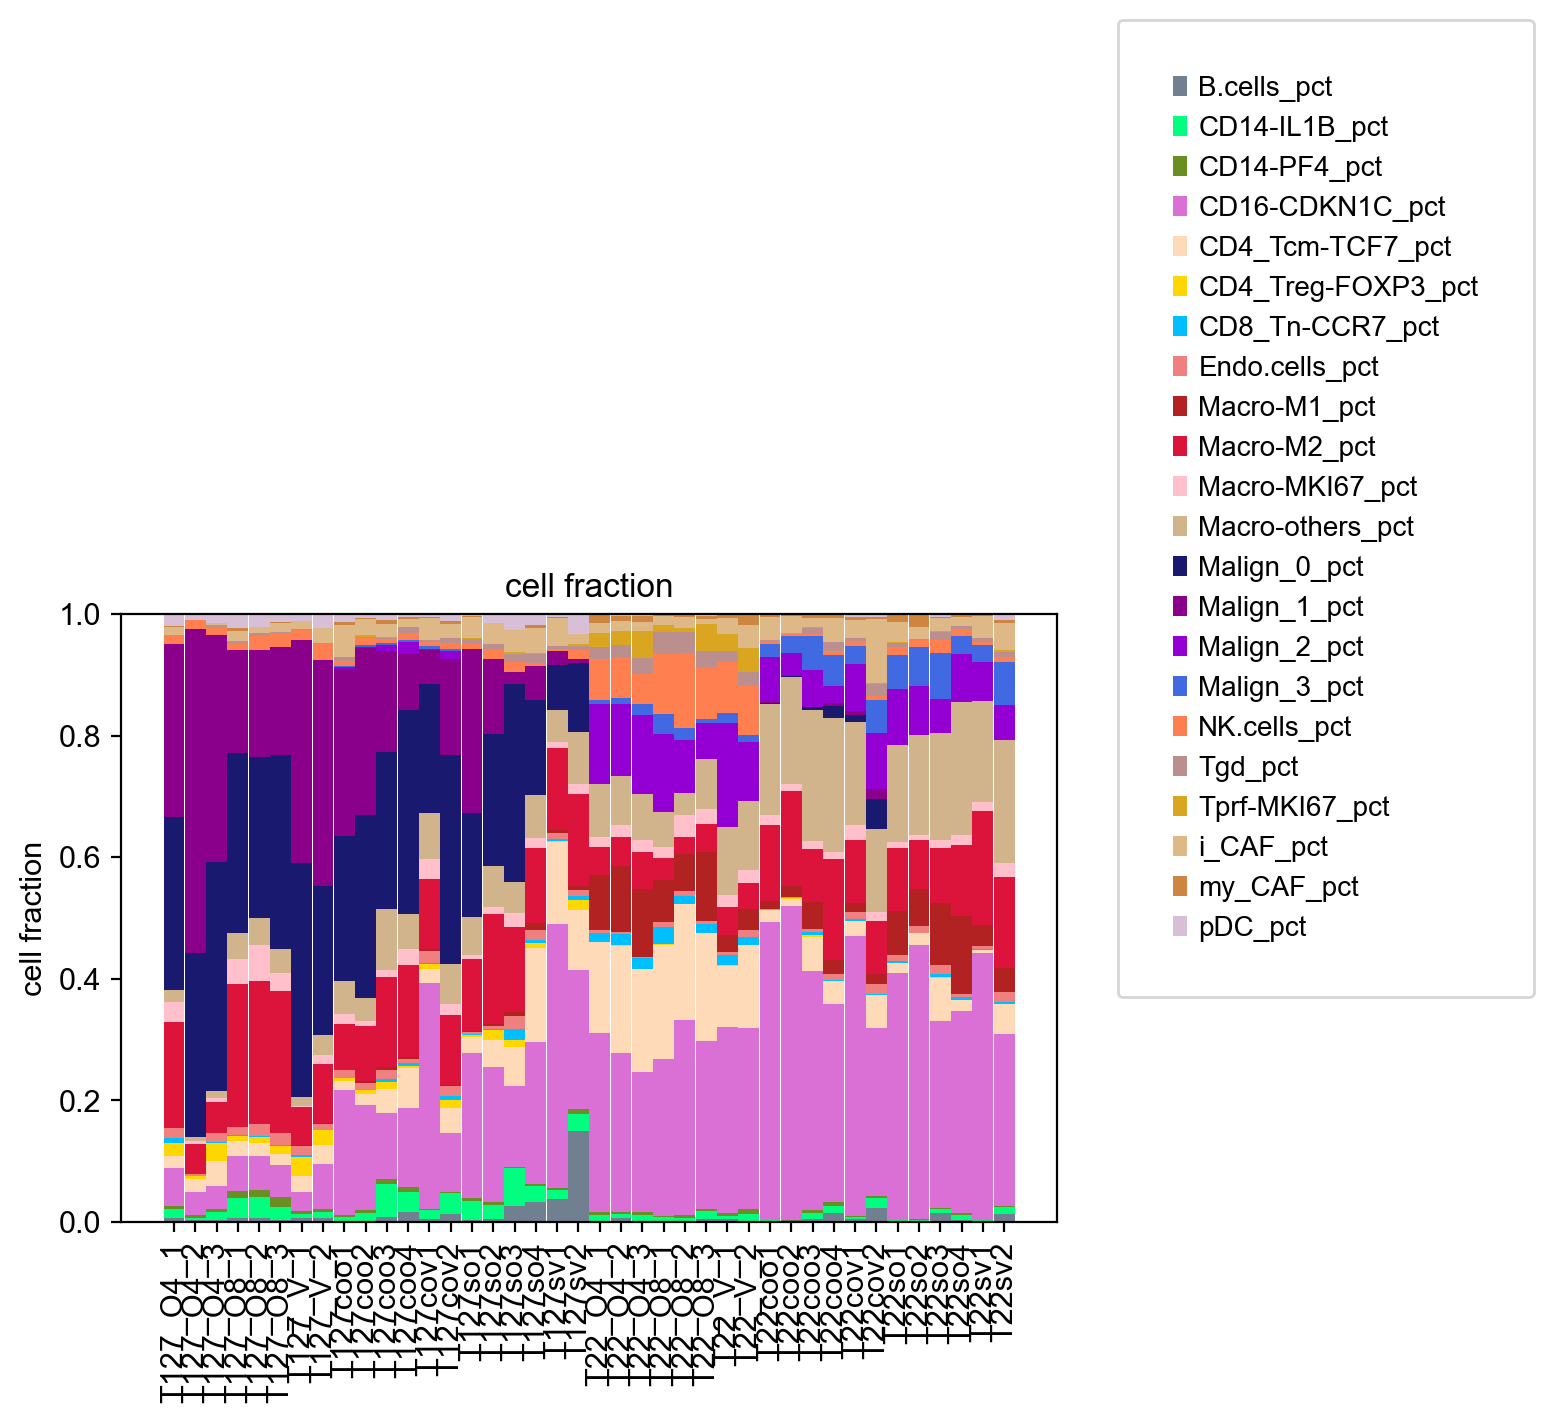

In [61]:
df_=fraction_
#plot the cell percentage bar chart
labels =np.unique(adata.obs[group_by])

width = 0.98    # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
x = np.arange(0, len(labels))
bottom=0
for i in range (0, len(df_.columns)): 
    ax.bar(x,  df_.iloc[:,i], width, yerr=None, label=df_.columns[i][:1], bottom=bottom, color=scv.utils.interpret_colorkey(adata[adata.obs[feature]==df_.iloc[:,i].name[:-4]],c=f"{feature}"))
    bottom=bottom+df_.iloc[:,i].values
    

plt.xticks(x, labels,rotation=90)
ax.set_ylabel('cell fraction')
ax.set_title('cell fraction')
legend=ax.legend(df_.columns,bbox_to_anchor=(1.05, 1,3,1), loc='upper left', prop={'size':10},borderpad=2)

fig.show()
fig.savefig(f"{project_ID}_figures/{feature}_fraction_{group_by}.pdf",bbox_extra_artists=(legend,),bbox_inches="tight",dpi=300)

## Export meta

In [71]:
#export the full matrix of spliced RNA
adata_=adata[((adata.obs_names.str.startswith("coGEX8")))]
#export meta data for R packages
meta_sample_clusters=pd.DataFrame(adata_.obs.anno_clusters)

meta_sample_clusters.to_csv(f"{project_ID}_DEG/meta_co_gex8.csv")

In [64]:
#export the full matrix of spliced RNA
adata_=adata[((adata.obs_names.str.startswith("T1"))&(adata.obs.treatment.str.startswith("T127_")))]
raw_=pd.DataFrame(data=adata_.raw.X.toarray(), index=adata_.obs_names, columns=adata_.raw.var_names)
matrix=raw_
#matrix.index=map(lambda x:x.upper(),matrix.index)
matrix.to_csv(f"./{project_ID}_DEG/matrix_T127_gex1_raw.csv",header=True)

In [ ]:
adata_=adata[adata.obs_names.str.startswith("coGEX6")]

In [ ]:
#export the full matrix of spliced RNA
matrix=adata_.copy().T.to_df()
#matrix.index=map(lambda x:x.upper(),matrix.index)
matrix.to_csv(f"./{project_ID}_DEG/coGEX6_matrix_raw.csv",header=True)

## Save h5ad

In [ ]:
sub_pop_name="Macro"
sub_pop=[adata.obs.anno_clusters[0].startswith(f"{sub_pop_name}")].obs_names

In [ ]:
#plot umap grouped by treatment
scv.pl.scatter(adata[sub_pop],save=f"{sub_pop_name}_cells_umap.pdf", 
               basis="umap",legend_loc="right",color="anno_clusters",
            size=10, alpha=0.8,
            )

In [ ]:
adata=sc.read(f"pool_reconcat.h5ad", gex_only=True)
adata.var_names_make_unique("_")
#adata_raw=adata_raw[adata.obs_names,:]
#adata_raw.obs["anno_clusters"]=adata.obs.anno_clusters

In [ ]:
adata.obs["Sample_ID"]=adata.obs.treatment

## correlation heatmap

In [ ]:
raw=pd.DataFrame(data.adata.raw.X.toarray(),index=adata.obs_names, columns=adata.raw.var_names)

In [ ]:
score_list=["latent_time","Regulon(Nfkb1(+))","Regulon(Mef2c(+))","Regulon(Irf8(+))","Regulon(Mef2a(+))","Regulon(Bcl11a(+))",
                      "Regulon(Bhlhe40(+))","Regulon(E2f7(+))","Regulon(Ezh2(+))",
                      "Regulon(Klf2(+))","Regulon(Maf(+))","Regulon(Spic(+))","Regulon(Tcf4(+))","protumor_cytokine_score",
            "reactome_phagocytosis_score","KEGG_phagocytosis_score","MM_GO_antigen_presentation_score","antitumor_cytokine_score",]
gene_list=["Cd209a","Csf1r","Il12b","Cd86","Itgax","Cd74","Cd44","Mrc1","Arg1","Msr1","Il10","Siglec1","Ccl8","C5ar1",]

In [ ]:
group="Sample"

In [ ]:
import math

In [ ]:
corr_list=np.array([])
for i in score_list:
    for k in score_list:
        x_label=i
        score_x = pd.DataFrame(adata_s.obs[x_label].values,columns=["score"],index=adata_s.obs[group])
        score_x = score_x.groupby(level=0).mean()
        
        y_label=k
        score_y = pd.DataFrame(adata_s.obs[y_label].values,columns=["score"],index=adata_s.obs[group])
        score_y = score_y.groupby(level=0).mean()
        
        x=score_x["score"].values
        y=score_y["score"]
        r,p = stats.pearsonr(x, y) 
        
        corr_list=np.append(corr_list,r)
index=np.array([])
for i in score_list:
    for k in score_list:
        index=np.append(index, i+"-"+k)
corr=pd.Series(corr_list, index=index)

In [ ]:
corr_list=np.array([])
for i in score_list:
    for k in gene_list:
        x_label=i
        score_x = pd.DataFrame(adata_s.obs[x_label].values,columns=["score"],index=adata_s.obs[group])
        score_x = score_x.groupby(level=0).mean()
        
        y_label=k
        gene_y = raw.loc[:,[y_label]]
        gene_y.index=adata_s.obs[group]
        gene_y =gene_y.groupby(level=0).mean()
        
        x=score_x["score"].values
        y=gene_y.loc[:,y_label].values
        r,p = stats.pearsonr(x, y) 
        
        corr_list=np.append(corr_list,r)
index=np.array([])
for i in score_list:
    for k in gene_list:
        index=np.append(index, i+"-"+k)
corr2=pd.Series(corr_list, index=index)

In [ ]:
corr_list=np.array([])
for i in gene_list:
    for k in gene_list:
        x_label=i
        gene_x = raw.loc[:,[x_label]]
        gene_x.index=adata_s.obs[group]
        gene_x =gene_x.groupby(level=0).mean()
        
        y_label=k
        gene_y = raw.loc[:,[y_label]]
        gene_y.index=adata_s.obs[group]
        gene_y =gene_y.groupby(level=0).mean()
        
        x=gene_x.loc[:,x_label].values
        y=gene_y.loc[:,y_label].values
        r,p = stats.pearsonr(x, y) 
        
        corr_list=np.append(corr_list,r)
index=np.array([])
for i in gene_list:
    for k in gene_list:
        index=np.append(index, i+"-"+k)
corr3=pd.Series(corr_list, index=index)

In [ ]:
corr_list=np.array([])
for i in gene_list:
    for k in score_list:
        x_label=i
        gene_x = raw.loc[:,[x_label]]
        gene_x.index=adata_s.obs[group]
        gene_x =gene_x.groupby(level=0).mean()
        
        y_label=k
        score_y = pd.DataFrame(adata_s.obs[y_label].values,columns=["score"],index=adata_s.obs[group])
        score_y = score_y.groupby(level=0).mean()
        
        x=gene_x.loc[:,x_label].values
        y=score_y["score"]
        r,p = stats.pearsonr(x, y) 
        
        corr_list=np.append(corr_list,r)
index=np.array([])
for i in gene_list:
    for k in score_list:
        index=np.append(index, i+"-"+k)
corr4=pd.Series(corr_list, index=index)

In [ ]:
corr_list=np.array([])
for i in score_list:
    for k in score_list:
        x_label=i
        score_x = pd.DataFrame(adata_s.obs[x_label].values,columns=["score"],index=adata_s.obs[group])
        score_x = score_x.groupby(level=0).mean()
        
        y_label=k
        score_y = pd.DataFrame(adata_s.obs[y_label].values,columns=["score"],index=adata_s.obs[group])
        score_y = score_y.groupby(level=0).mean()
        
        x=score_x["score"].values
        y=score_y["score"]
        r,p = stats.pearsonr(x, y) 
        
        corr_list=np.append(corr_list,math.log10(p+math.exp(-7)))
index=np.array([])
for i in score_list:
    for k in score_list:
        index=np.append(index, i+"-"+k)
pvalues=pd.Series(corr_list, index=index)

In [ ]:
corr_list=np.array([])
for i in score_list:
    for k in gene_list:
        x_label=i
        score_x = pd.DataFrame(adata_s.obs[x_label].values,columns=["score"],index=adata_s.obs[group])
        score_x = score_x.groupby(level=0).mean()
        
        y_label=k
        gene_y = raw.loc[:,[y_label]]
        gene_y.index=adata_s.obs[group]
        gene_y =gene_y.groupby(level=0).mean()
        
        x=score_x["score"].values
        y=gene_y.loc[:,y_label].values
        r,p = stats.pearsonr(x, y) 
        
        corr_list=np.append(corr_list,math.log10(p+math.exp(-7)))
index=np.array([])
for i in score_list:
    for k in gene_list:
        index=np.append(index, i+"-"+k)
pvalues2=pd.Series(corr_list, index=index)

In [ ]:
corr_list=np.array([])
for i in gene_list:
    for k in gene_list:
        x_label=i
        gene_x = raw.loc[:,[x_label]]
        gene_x.index=adata_s.obs[group]
        gene_x =gene_x.groupby(level=0).mean()
        
        y_label=k
        gene_y = raw.loc[:,[y_label]]
        gene_y.index=adata_s.obs[group]
        gene_y =gene_y.groupby(level=0).mean()
        
        x=gene_x.loc[:,x_label].values
        y=gene_y.loc[:,y_label].values
        r,p = stats.pearsonr(x, y) 
        
        corr_list=np.append(corr_list,math.log10(p+math.exp(-7)))
index=np.array([])
for i in gene_list:
    for k in gene_list:
        index=np.append(index, i+"-"+k)
pvalues3=pd.Series(corr_list, index=index)

In [ ]:
corr_list=np.array([])
for i in gene_list:
    for k in score_list:
        x_label=i
        gene_x = raw.loc[:,[x_label]]
        gene_x.index=adata_s.obs[group]
        gene_x =gene_x.groupby(level=0).mean()
        
        y_label=k
        score_y = pd.DataFrame(adata_s.obs[y_label].values,columns=["score"],index=adata_s.obs[group])
        score_y = score_y.groupby(level=0).mean()
        
        x=gene_x.loc[:,x_label].values
        y=score_y["score"]
        r,p = stats.pearsonr(x, y) 
        
        corr_list=np.append(corr_list,math.log10(p+math.exp(-7)))
index=np.array([])
for i in gene_list:
    for k in score_list:
        index=np.append(index, i+"-"+k)
pvalues4=pd.Series(corr_list, index=index)

In [ ]:
corr_total=pd.concat([corr, corr2,corr3,corr4])
corr_total=pd.DataFrame(corr_total, columns=["R"])
X=np.array([])
Y=np.array([])
for i in range(0,len(corr_total)):
    X=np.append(X, corr_total.index[i].split("-")[0])
    Y=np.append(Y, corr_total.index[i].split("-")[1])
corr_total.loc[:,"X"]=X
corr_total.loc[:,"Y"]=Y
corr_total.loc[:,"pvalues"]=pd.concat([pvalues, pvalues2,pvalues3,pvalues4])

In [ ]:
star=np.array([])
for i in range(0,len(corr_total)):
    if ((corr_total.loc[:,"pvalues"][i]<-1.3) & (abs(corr_total.loc[:,"R"][i])>0.3)):
        star=np.append(star, 60)
    else:
        star=np.append(star,0)
corr_total.loc[:,"star"]=star

In [ ]:
plt.figure(figsize = (3.5,3.5))  #set figure size

#fig, (ax) = plt.subplots(1, 1, figsize=(2,3), dpi=100)
 

plt.scatter(corr_total.loc[:,"X"], corr_total.loc[:,"Y"], c=-corr_total.loc[:,"pvalues"],
            s=corr_total.loc[:,"R"]*200,alpha=1, linewidths=0, cmap="YlOrRd", marker="o") # plot scatters
plt.scatter(corr_total.loc[:,"X"], corr_total.loc[:,"Y"], c=-corr_total.loc[:,"pvalues"],
            s=-corr_total.loc[:,"R"]*200,alpha=1, linewidths=0, cmap="GnBu",marker="o")
plt.scatter(corr_total.loc[:,"X"], corr_total.loc[:,"Y"], c="white",s=corr_total.loc[:,"star"],alpha=1, linewidths=0, marker="*")# plot scatters

#map1 = ax.imshow(np.stack([corr_total.loc[:,"pvalues"],corr_total.loc[:,"pvalues"]]),cmap='YlOrRd')
#map2 = ax.imshow(np.stack([-corr_total.loc[:,"pvalues"],-corr_total.loc[:,"pvalues"]]),cmap='GnBu')

#plt.colorbar(map1)
#plt.colorbar(map2)

s4 = plt.scatter([],[], s=40, marker='o', color='#555555')
s6 = plt.scatter([],[], s=60, marker='o', color='#555555')
s10 = plt.scatter([],[], s=100, marker='o', color='#555555')
plt.legend((s4,s6,s10),
       ('0.2', '0.3', '0.5'),
       scatterpoints=1,
       loc='best',
       ncol=1,
       fontsize=8)
#make the file that we will store these plots in 
try:
    directoryName=project_ID+"_DEG"
    os.mkdir(directoryName)
except:
    pass

plt.savefig(f"{project_ID}_DEG/pearson_panel_total_mRNA_macrophage.pdf",dpi=300)
plt.show()  # show plots

In [63]:
#export meta data for R packages
meta_sample_clusters=pd.concat([adata.obs.anno_clusters,adata.obs.Sample, adata.obs.treatment,adata.obs.term, adata.obs.strain],axis=1)
meta_sample_clusters.to_csv(f"{project_ID}_DEG/meta_reconcat.csv")